<a href="https://colab.research.google.com/github/AritroGomes/INST414/blob/main/Wikipedia_Cannabis_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --------------------------------------------------------
# Wikipedia Cannabis Network - Node Collection Script
# Author: Aritro Gomes
# Course: INST414 / University of Maryland
# Date: 10/03/2025
# Description:
#   This script collects all U.S. state-level cannabis pages
#   from Wikipedia and saves them as a CSV file of nodes.
# --------------------------------------------------------

In [ ]:
import requests
import pandas as pd
from datetime import datetime

# Setting up the API base URL and headers
BASE = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "UMD-Inst414-StudentProject/1.0 (contact: agomes03@terpmail.umd.edu)"
}

# Defining the API parameters
params = {
    "action": "query",
    "list": "categorymembers",
    "cmtitle": "Category:Cannabis_in_the_United_States_by_state",
    "cmtype": "page",
    "cmlimit": "max",
    "format": "json",
    "formatversion": "2"
}

# Collecting all pages within the category
pages = []
while True:
    r = requests.get(BASE, params=params, headers=HEADERS, timeout=30)
    r.raise_for_status()  # ensures connection worked
    data = r.json()
    pages.extend(data["query"]["categorymembers"])
    if "continue" in data:
        params["cmcontinue"] = data["continue"]["cmcontinue"]
    else:
        break

# Creating a DataFrame of page IDs and titles
df_nodes = pd.DataFrame(pages)[["pageid", "title"]].drop_duplicates()

# Optional cleanup: keep only titles that start with "Cannabis in "
df_nodes = df_nodes[df_nodes["title"].str.startswith("Cannabis in ")]

# Saving to CSV and display summary
df_nodes.to_csv("cannabis_state_pages.csv", index=False)
print(f"Collected {len(df_nodes)} state pages on {datetime.utcnow().isoformat()}Z")
df_nodes.head()

Collected 18 state pages on 2025-10-10T09:06:33.642665Z


/tmp/ipython-input-3611918861.py:42: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"Collected {len(df_nodes)} state pages on {datetime.utcnow().isoformat()}Z")


,pageid,title
0,52211777,Cannabis in Connecticut
1,52210188,Cannabis in Delaware
2,52183921,Cannabis in Mississippi
4,47623113,Cannabis in Alabama
5,48920848,Cannabis in Alaska


In [ ]:
import time

titles = set(df_nodes["title"])
id2title = dict(zip(df_nodes["pageid"], df_nodes["title"]))

edges = []

for pid in df_nodes["pageid"]:
    # paginate through all links for this page
    params = {
        "action": "query",
        "prop": "links",
        "pageids": pid,
        "plnamespace": "0",
        "pllimit": "max",
        "format": "json",
        "formatversion": "2"
    }
    while True:
        r = requests.get(BASE, params=params, headers=HEADERS, timeout=30)
        r.raise_for_status()
        data = r.json()
        page = data["query"]["pages"][0]
        for link in page.get("links", []):
            tgt = link["title"]
            if tgt in titles:
                edges.append((id2title[pid], tgt))
        if "continue" in data:
            params["plcontinue"] = data["continue"]["plcontinue"]
        else:
            break
    time.sleep(0.1)  # be polite

df_edges = pd.DataFrame(edges, columns=["source","target"]).drop_duplicates()
df_edges.to_csv("cannabis_state_edges.csv", index=False)
print(len(df_edges), "edges"); df_edges.head()


361 edges


,source,target
0,Cannabis in Connecticut,Cannabis in Alabama
1,Cannabis in Connecticut,Cannabis in Alaska
2,Cannabis in Connecticut,Cannabis in Arizona
3,Cannabis in Connecticut,Cannabis in California
4,Cannabis in Connecticut,Cannabis in Delaware


In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(df_edges, "source","target", create_using=nx.DiGraph())

pr = nx.pagerank(G)
top3 = sorted(pr.items(), key=lambda x: x[1], reverse=True)[:3]
print("Top 3 by PageRank:", top3)


Top 3 by PageRank: [('Cannabis in Connecticut', 0.05223684210526315), ('Cannabis in Alabama', 0.05223684210526315), ('Cannabis in Alaska', 0.05223684210526315)]


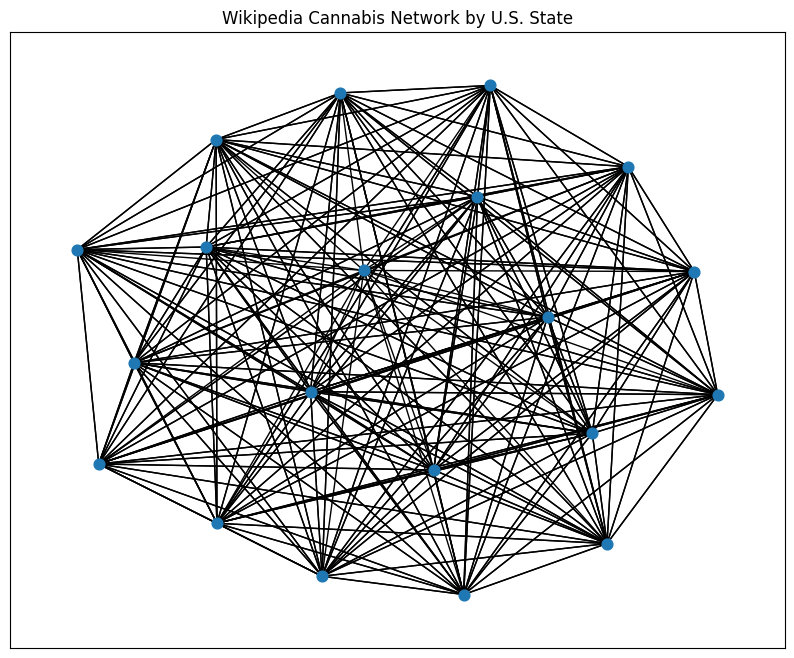

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
nx.draw_networkx(G, with_labels=False, node_size=60, arrows=False)
plt.title("Wikipedia Cannabis Network by U.S. State")
plt.show()


In [ ]:
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

print("Top by Degree:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3])
print("Top by Betweenness:", sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:3])


Top by Degree: [('Cannabis in Connecticut', 1.9473684210526314), ('Cannabis in Alabama', 1.9473684210526314), ('Cannabis in Alaska', 1.9473684210526314)]
Top by Betweenness: [('Cannabis in Connecticut', 0.0), ('Cannabis in Alabama', 0.0), ('Cannabis in Alaska', 0.0)]
